In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly import subplots
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Load train and test Datasets
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

train.head()

<a id='title'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">Titanic 🚢 | DiCaprio's Safety Guide</p>

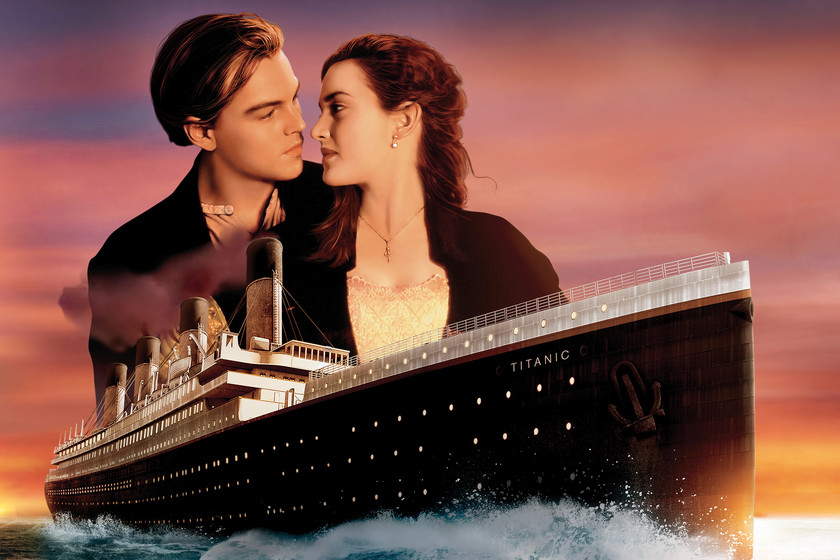

In [ ]:
report = ProfileReport(train)

In [ ]:
report

### Variable Notes

**pclass**: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
**Sibling** = brother, sister, stepbrother, stepsister
**Spouse** = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Data visualization</p>

First of all, lets check the variables

### Pclass

In [ ]:
fig = px.histogram(train, x='Pclass', color='Pclass')
fig.update_xaxes(type='category')
fig.show()

In [ ]:
fig = px.histogram(train, x='Pclass', color='Sex')
fig.update_xaxes(type='category')
fig.show()

In [ ]:
# Explore Pclass vs Survived
g = sns.catplot(x="Pclass",y="Survived",data=train, kind="bar", height=6 , palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Conclusiones: 
* As we can see, the most part of the crew was in from the **3º class**.
* Its curious that the second mayority class is **1º class**. It could be explanided because it was an important ship and many rich people wanted to join the trip.
* We can also conclude that the **1º class have more chances to sirvive**.

### Sex

In [ ]:
fig = px.histogram(train, x='Sex', color='Sex')
fig.update_xaxes(type='category')
fig.show()

In [ ]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, height=6, kind="bar")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It is obvious that Male have less chance to survive than Female.

### Embarked

In [ ]:
fig = px.histogram(train[~train['Embarked'].isna()], x='Embarked', color='Embarked')
fig.update_xaxes(type='category')
fig.show()

In [ ]:
# Explore Embarked vs Survived 
g = sns.catplot(x="Embarked", y="Survived", data=train, height=6, kind="bar")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that people embarked from Cherbourg (C) have more chance to survive.

### SibSP

In [ ]:
fig = px.histogram(train, x='SibSp', color='SibSp')
fig.update_xaxes(type='category')
fig.show()

In [ ]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp",y="Survived", data=train, kind="bar", height=6)
g.despine(left=True)
g = g.set_ylabels("survival probability")

Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive

### Age

In [ ]:
fig = px.histogram(train[~train['Age'].isna()], x='Age')
fig.show()

In [ ]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=g, color="Blue", shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

The peak between 0 and 10 years corresponds to those children that were prioriced in the saving order (not you DiCaprio).

### Fare

In [ ]:
# Explore Fare distribution 
g = sns.distplot(train["Fare"], color="m", label="Skewness : %.2f"%(train["Fare"].skew()))
g = g.legend(loc="best")

This variable is high skewed so we will have to take care about it.

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Feature Engineering</p>

## 2.1 Join train and test

Firstly join both dataset so we can handle data cleaning and feature creation in both dfs at the same time!

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_indexs = train.index
test_indexs = test.index

df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
df = df.drop('PassengerId', axis=1)

len(train_indexs), len(test_indexs)

## 2.2 Fill missings

In [ ]:
df.isna().sum()

Survived missing values corresponds to the test parts so we should take care of it.

In [ ]:
# Fill Fare missing values with the median value
df["Fare"] = df["Fare"].fillna(df["Fare"].median())

# Fill Embarked nan values of dataset with the mode
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

In [ ]:
df['Fare'].isna().sum(), df['Embarked'].isna().sum()

### Fill Age missings

As Age has too manu missing, i will take care of this variable separately.

In [ ]:
# Fill Age with the median age of similar rows according to Pclass and SibSp
# If no similar crew memeber are found, we will use the full crew age's median
nan_age_ids = list(df["Age"][df["Age"].isnull()].index)

for i in nan_age_ids :
    age_med = df["Age"].median()
    age_pred = df["Age"][((df['SibSp'] == df.iloc[i]["SibSp"]) & (df['Pclass'] == df.iloc[i]["Pclass"]))].median()
    
    if not np.isnan(age_pred) :
        df['Age'].iloc[i] = age_pred
    else :
        df['Age'].iloc[i] = age_med

In [ ]:
df['Age'].isna().sum()

### Fill Cabin missings

As Cabin has too manu missing, i will take care of this variable separately.

In [ ]:
df["Cabin"][df["Cabin"].notnull()].head()

As we can see, it seems that the first letter represent the area in the boat were the passenger was traveling.

We are going to rebuild the variable with the first letter and we are going to assing a random letter to nans.

In [ ]:
# Replace the Cabin number by the type of cabin. 'Z' if missing
df["Cabin"] = df['Cabin'].apply(lambda x: 'Z' if pd.isnull(x) else x[0])

df['Cabin'].isna().sum()

In [ ]:
g = sns.catplot(y="Survived",x="Cabin", data=df, kind="bar", order=['A','B','C','D','E','F','G','T','Z'])
g = g.set_ylabels("Survival Probability")

### Lets check correlation

In [ ]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# plot heatmap
sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

## 2.3 Transform variables

### Tickets analysis

In [ ]:
df['Ticket'].head()

In this case, we are going to try the same idea that we used in 'Cabin' variable.

We are going to applay to each vale:
* Replace dot (.) with space
* Remove bars (/)

Now we camn get the first item.

In [ ]:
df['Ticket'] = df['Ticket'].apply(lambda x: 'Z' if x.isdigit() else x.replace('.',' ').replace('/','').strip().split(' ')[0])
df['Ticket'].head()

### Name analysis

As we can see, each name has a particle which informs about the social status.

We are goint to take it and create a new variable (as name doesnt seem to be a good opciones).

In [ ]:
df['Title'] = df['Name'].apply(lambda x: x.split('.')[0].split(' ')[-1])
df['Title'].value_counts()

In [ ]:
# Now we can drop Name column
df = df.drop('Name', axis=1)

Now we have to replace the Rare Titles.

In [ ]:
df["Title"] = df["Title"].replace(
    ['Lady','Countess','Capt', 'Mme', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Mlle', 'Ms'], 
    'Rare'
)
df["Title"] = df["Title"].replace(
    'Miss', 
    'Mrs'
)
df['Title'].value_counts()

In [ ]:
g = sns.catplot(x="Title", y="Survived", data=df, kind="bar")
g = g.set_ylabels("survival probability")

As we can see, women have more chance to be saved.

## 2.4 Fix numerical variables

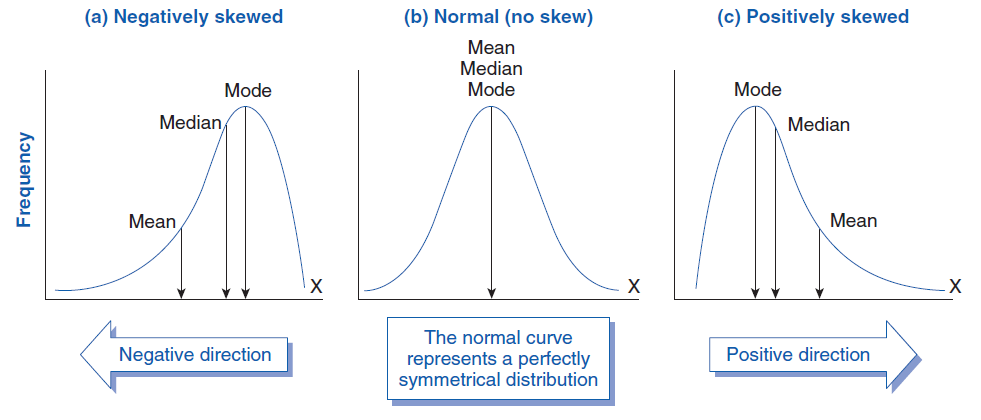

As we saw, Fare is a skewed variable so we can transform it with log function to adapt the values

In [ ]:
# Explore Fare distribution 
g = sns.distplot(df["Fare"], color="m", label="Skewness : %.2f"%(df["Fare"].skew()))
g = g.legend(loc="best")

In [ ]:
df["Fare"] = np.log1p(df["Fare"])

# lets see the distribution now
g = sns.distplot(df["Fare"], color="m", label="Skewness : %.2f"%(df["Fare"].skew()))
g = g.legend(loc="best")

Nice! we have fixed it up!

## 2.5 Create new variables

In [ ]:
# Create a family size descriptor from SibSp and Parch for himself
df["Fsize"] = df["SibSp"] + df["Parch"] + 1

In [ ]:
# Create new feature of family size
df['Single'] = df['Fsize'].map(lambda s: 1 if s == 1 else 0)
df['SmallF'] = df['Fsize'].map(lambda s: 1 if  2 <= s <= 3  else 0)
df['LargeF'] = df['Fsize'].map(lambda s: 1 if s >= 4 else 0)

## 2.6 Variable Encoding

In [ ]:
# Finding all the categorical columns from the data
categorical_columns = df.select_dtypes(exclude=['int64','float64']).columns
numerical_columns = df.drop('Survived', axis=1).select_dtypes(include=['int64','float64']).columns
categorical_columns

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['Sex'] = le.fit_transform(df['Sex'])

### One-Hot Encoding

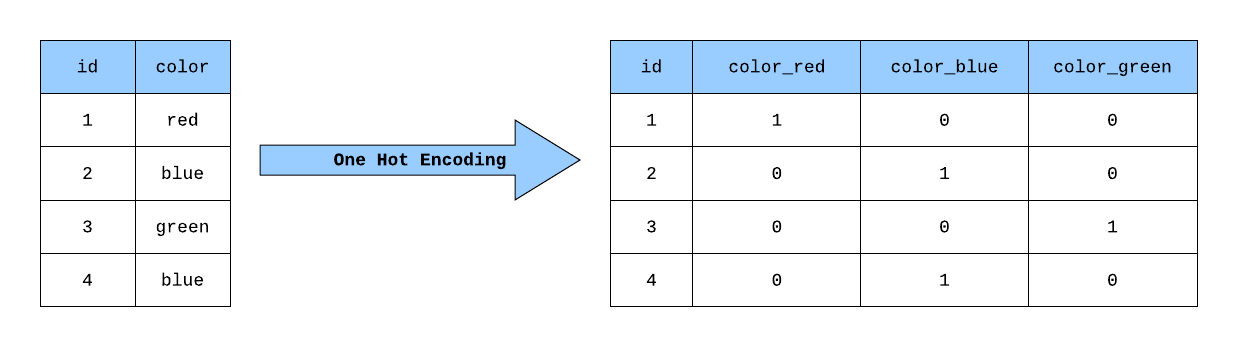

In [ ]:
categorical_columns = df.select_dtypes(exclude=['int64','float64']).columns
categorical_columns

In [ ]:
# One hot encoding independent variable x
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [ ]:
for feature in categorical_columns:
    df = encode_and_bind(df, feature)

df.head()

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Feature selection</p>

As this is a short problem (with low number of variables) and loew number of rows, its not necessary for now to reduce the dimensionality of the problem!

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Modelling</p>



Firstly we are going to split the dataframe

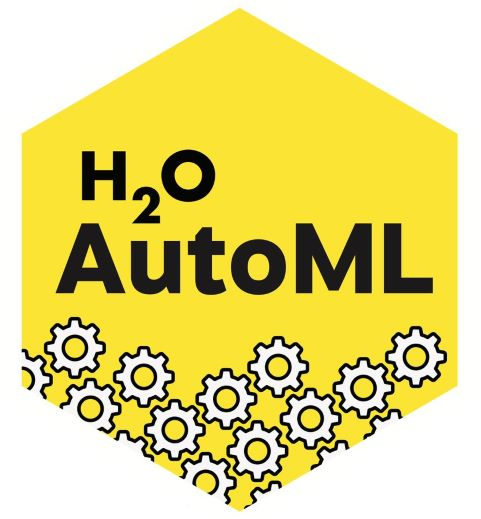

In [ ]:
## Separate train dataset and test dataset

train = df.loc[train_indexs]
test = df[len(train_indexs):]
test = test.drop(labels=["Survived"], axis=1)

In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

In [ ]:
hf = h2o.H2OFrame(train)
test_hf = h2o.H2OFrame(test)
hf.head()

In [ ]:
# Select the predictor variables and the target
hf['Survived'] = hf['Survived'].asfactor()
predictors = hf.drop('Survived').columns
response = 'Survived'

In [ ]:
# Split into train and test
train_hf, valid_hf = hf.split_frame(ratios=[.8], seed=1234)

In [ ]:
# Add a Stopping Creterias: max number of models and max time
# We are going to exclude DeepLearning algorithms because they are too slow
aml = H2OAutoML(
    max_models=20,
    max_runtime_secs=300,
    seed=1234,
    # exclude_algos = ["DeepLearning"]
)

In [ ]:
# Train the model
aml.train(x=predictors,
        y=response,
        training_frame=hf,
)

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=5)  # Print the first 5 rows

In [ ]:
valid_pred = aml.leader.predict(valid_hf)

In [ ]:
metrics.accuracy_score(valid_pred.as_data_frame()['predict'], valid_hf.as_data_frame()['Survived'])

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Submission</p>

In [ ]:
test_ids = pd.read_csv('/kaggle/input/titanic/test.csv')['PassengerId']

In [ ]:
test_pred = aml.predict(test_hf)

In [ ]:
submission = pd.concat([test_ids, test_pred.as_data_frame()['predict']], axis=1)
submission.columns = ['PassengerId', 'Survived']
submission.head()

In [ ]:
submission.to_csv("submission_h2o_automl.csv",index=False)